![Clarify Logo](https://global-uploads.webflow.com/5e81e464dad44d3a9a32d1f4/5ed10fc3f1ff8467f4466786_logo.svg)


**Welcome to the Clarify Forecast tutorial!** 📈 

This notebook start from the point that you can get credentials, authentication token, and read data directly from Clarify, and then proceed to show how to perform forecasting and writting the result back into Clarify.

<img src="../media/forecast/analysis_work.jpg" alt="Additional Options" style="width: 60%;" />






# Prerequistes 
* [Clarify](https://www.clarify.io) Account
* [Basic tutorial on using Python with Clarify](https://colab.research.google.com/github/searis/data-science-tutorials/blob/main/tutorials/Introduction.ipynb)
    - Check this tutorial for more details about reading and writting data using the PyClarify interface
* Credential file `clarify-credentials.json` from Clarify, available to the environment runnning this notebook.


# What we will do

1. [Read and plot item data from Clarify](#read)
2. [Apply a Pattern Recognition Algorithm](#apply)
3. [Create Patterns](#create)
4. [Write signal data and metadata to Clarify](#write)
3. [Visualise the results in Clarify](#visualise)

---
Other resources:
* [Basic tutorial on using Python with Clarify](https://colab.research.google.com/github/searis/data-science-tutorials/blob/main/tutorials/Introduction.ipynb)
* [API reference](https://docs.clarify.io/reference/http)
* [SDK documentation](https://searis.github.io/pyclarify/)
* [Merlion - time-series forecast and anomaly detection library](https://opensource.salesforce.com/Merlion/v1.0.1/tutorials.html)

## <a name="start"></a> Getting started
We will be using the PyClarify SDK for authentication, reading and writing signals to the Clarify app. The SDK is mirroring the Clarify API, thus [the reference document](https://docs.clarify.io/reference) will be a good resource if you come across any issues or want to see the capabilities of the API. 

In [ ]:
# install dependencies
!pip install requests pyclarify pandas matplotlib salesforce-merlion 

In [3]:
import pandas as pd
from datetime import datetime, timedelta
from pyclarify import APIClient
client = APIClient("./clarify-credentials.json")

### Reading Meta data
You can retrieve the items data and meta-data from the Clarify API. This is useful in case you want to have a list of items that you have access in the script you are running. Also the items id are necessary when retrieving data from Clarify.

In [4]:
from pyclarify.models.requests import ItemSelect
empty_request = {
  "items": {
    "include": True, 
  }, 
  "times": {
  }, 
  "series": {
  }
}
meta_data_params = ItemSelect(**empty_request)

To obtain the result we call the method `select_items` with returns a JSON with a field `result` and sub-field `items` with a dictionary of item ids and metadata. 

In [5]:
response = client.select_items(meta_data_params)
signal_dict = response.result.items
for signal, meta_data in signal_dict.items():
  print(f"ID: {signal} \t Name: {meta_data.name}")

ID: c1vcfb2005qb5nusi15g 	 Name: Noise
ID: c1vcgea005qb5nusi7pg 	 Name: Temperature
ID: c1vcl2q005qb5nusjhag 	 Name: CO2
ID: c1vcl5a005qb5nusji60 	 Name: Pressure
ID: c1vcl7q005qb5nusjjs0 	 Name: Humidity
ID: c2186s2005qb5nut9st0 	 Name: CTR
ID: c2186ua005qb5nut9t2g 	 Name: Google Search Impressions
ID: c21870a005qb5nut9t8g 	 Name: Clicks
ID: c21872q005qb5nut9td0 	 Name: Position
ID: c21ch8a005qb5nutcbbg 	 Name: Bounce rate


The default behavior of the `select_items` method is to return a list of items limit defined by the API. If you want to list all items that you have access to, you can iterate over the result list and make subsequent calls to the API asking to skip an amount of items given by the `skip` parameter. We will show an example of how to list all the items that you have access to. 

### Reading data

Now, given the list of items that you have access to, you can choose one id of interest to retrieve data from.

In [23]:
item_id = "c1vcgea005qb5nusi7pg"

reading_data_request = {
  "items": {
    "include": True,
    "filter": {
      "id": {
        "$in": [
          item_id
        ]
      }
    }
  },
  "times": {
    "notBefore": "2021-08-07T07:14:19Z" #starting from 
  },
  "series": {
    "items": True,
    "aggregates": False
  }
}

data_params = ItemSelect(**reading_data_request)

response = client.select_items(data_params)
signal_name = list(response.result.items.values())[0].name
times = response.result.data.times
series = response.result.data.series

We procced by converting the data from our internal `DataFrame` structure to `pandas.DataFrame` in order to use in the forecasting library. We also discard that timezone information because the forecasting library does not support timezones, we can save that information for later when inserting the forecast data back into Clarify. 

718


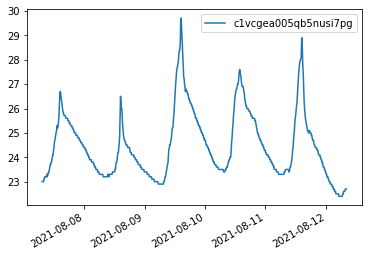

In [24]:
import pandas as pd
df = pd.DataFrame(series)
df.index = [time.replace(tzinfo=None) for time in times]
if len(times) > 0:
    tzinfo = times[0].tzinfo
df.plot()
print(len(times))

# Forecasting

Given a sequence values in a time window, we might wonder that could be likely possible values on that timeseries. The task of forecasting values of a timeseries is defined as a task where taking the values until a certain time, we predict possible future values for the timeseries. 

In order to do so, we will start by exploring the forecast models available in the library [`merlion`](https://opensource.salesforce.com/Merlion/v1.0.0/index.html). This library encapsulates multiple forecast methods, for for single signals, multiple signals and allow for easy modular experimentation with the algorithms, as well as composing and creating ensembles. We will only show the basic functionality here.

## Single signal forecasting



The basic elements for using the `merlion` forecasting library is the `TimeSeries` data structure, transformations to the data, and the configuration and forecasting model. In this case we choose to use the `Prophet` forecasting model, which means that we need to instantiate a `ProphetConfig` object, defining for example de maximum forecast steps, seasonality and transformation on the data (which is this case is the `Identity` transformation).
- For an in-depth tutorial of forecasting using `merlion` check the [official documentation](https://opensource.salesforce.com/Merlion/v1.0.1/examples/forecast/1_ForecastFeatures.html)

In [19]:
from merlion.utils import TimeSeries
from merlion.models.forecast.prophet import Prophet, ProphetConfig
from merlion.transform.base import Identity
import matplotlib.pyplot as plt


test_data = TimeSeries.from_pd(df[-150:])
train_data = TimeSeries.from_pd(df[0:-150])
config = ProphetConfig(max_forecast_steps=50, add_seasonality="auto", transform=Identity())
model  = Prophet(config)
model.train(train_data=train_data)
test_pred, test_err = model.forecast(time_stamps=test_data.time_stamps)



ModuleNotFoundError: No module named 'merlion'

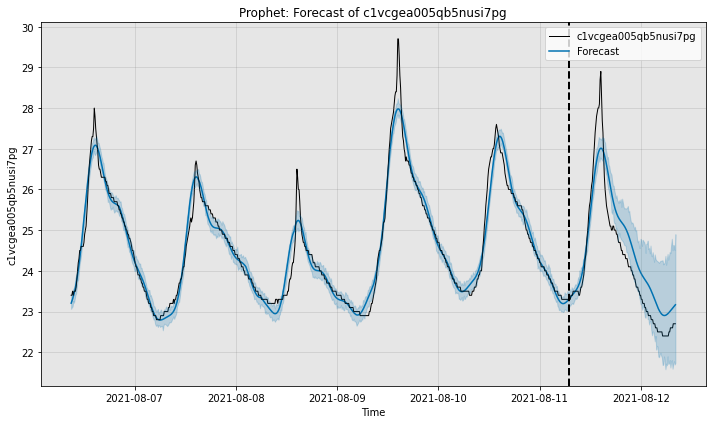

In [77]:
fig, ax = model.plot_forecast(time_series_prev =train_data,time_series=test_data, plot_forecast_uncertainty=True, plot_time_series_prev=True)
plt.show()

We can now write back to Clary by creating DataFrames and metadata for the generated forecast and calling the method `insert` from `pyclarify`

In [126]:
from pyclarify import Signal, DataFrame

def write_data_and_metadata(original, new_name, times, series):
        new_signal_name = new_name
        new_signal_id = new_name
        args = { "name" : new_signal_name, "description" : f"Forecast for {original}"}
        
        new_signal_meta_data = Signal(**args)

        response = client.save_signals(
            inputs={new_signal_id : new_signal_meta_data},
            created_only=False #False = create new signal, True = update existing signal
        )

        new_df = DataFrame(times=times, series=series)
        response = client.insert(new_df)
        print(response)

col = test_pred.names[0]
col_err = test_err.names[0]
forecast_name=col+"_pred"
forecast_name_upper=col+"_upper"
forecast_name_lower=col+"_lower"

forecast_values = test_pred.univariates[col].values
forecast_upper_values= [x+y for x,y in zip(test_pred.univariates[col].values, test_err.univariates[col_err].values)]
forecast_lower_values= [x-y for x,y in zip(test_pred.univariates[col].values, test_err.univariates[col_err].values)]

df_forecast = DataFrame(times = test_data.time_stamps, series={forecast_name: forecast_values })
df_forecast_upper = DataFrame(times = test_err.time_stamps, 
                              series={forecast_name_upper: forecast_upper_values})
df_forecast_lower = DataFrame(times = test_err.time_stamps, 
                              series={forecast_name_lower:forecast_lower_values })

write_data_and_metadata(item_id, forecast_name, df_forecast )
write_data_and_metadata(item_id, forecast_name_upper, df_forecast_upper )
write_data_and_metadata(item_id, forecast_name_lower, df_forecast_lower )

## Visualize the forecast result and collaborate with Clarify
<img src="../media/forecast/clarify_forecast_comment.png" alt="Additional Options"  />

Once your data is written via the Clarify API and you have created **items** for the forecast and the bounds of the interval characterizing the uncertainty of the forecast, you can create customized **timelines** with your data. Clarify facilitates the creation of dynamic and responsive graph visualization and collaboration around the generated forecast, for example with the possibility of creating threads of comments on a point or interval of time, as illustrated in the above figure.